In [1]:
import math
import numpy as np
import torch
import sys
import torch.nn as nn
import torch.nn.functional as F
from timeit import default_timer
import sys
import os
sys.path.append("../../")
from utility.adam import Adam
from utility.losses import LpLoss
from utility.normalizer import UnitGaussianNormalizer
from pcno.geo_utility import compute_edge_gradient_weights

In [61]:

equal_weights = True
data_path = "../../data/adv_diff_bvp/"
data = np.load(data_path+"pcno_data.npz")
nnodes, node_mask, nodes = data["nnodes"], data["node_mask"], data["nodes"]
node_weights = data["node_equal_weights"] if equal_weights else data["node_weights"]
directed_edges, edge_gradient_weights = data["directed_edges"], data["edge_gradient_weights"]
features = data["features"]
node_measures = data["node_measures"]
node_measures_raw = data["node_measures_raw"]
indices = np.isfinite(node_measures_raw)
node_rhos = np.copy(node_weights)
node_rhos[indices] = node_rhos[indices]/node_measures[indices]

features /= np.array([1.0, 1.0, 0.01, 1.0])
nnodes = torch.from_numpy(nnodes)
node_mask = torch.from_numpy(node_mask)
nodes = torch.from_numpy(nodes.astype(np.float32))
node_weights = torch.from_numpy(node_weights.astype(np.float32))
node_rhos = torch.from_numpy(node_rhos.astype(np.float32))
features = torch.from_numpy(features.astype(np.float32))
directed_edges = torch.from_numpy(directed_edges.astype(np.int64))
edge_gradient_weights = torch.from_numpy(edge_gradient_weights.astype(np.float32))

nodes_input = nodes.clone()
N = nnodes.shape[0]
x_all = torch.cat((features[:,:,[0,2,3]],nodes_input, node_rhos), -1)
aux_all = (node_mask,  nodes,  node_weights,  directed_edges,  edge_gradient_weights)
y_all = features[:, :, [1]]
print('x_all.shape: ',x_all.shape,' y_all.shape: ',y_all.shape , 'node_mask.shape: ',node_mask.shape)
all_tuple = (x_all,y_all,node_mask,nodes,node_weights,directed_edges,edge_gradient_weights)


normalization_x = True
normalization_y = True
normalization_dim_x = []
normalization_dim_y = []
non_normalized_dim_x = 2
non_normalized_dim_y = 0

config = {"train" : {"normalization_x": normalization_x,"normalization_y": normalization_y, 
                     "normalization_dim_x": normalization_dim_x, "normalization_dim_y": normalization_dim_y, 
                     "non_normalized_dim_x": non_normalized_dim_x, "non_normalized_dim_y": non_normalized_dim_y}
                     }

x_all.shape:  torch.Size([7500, 7501, 5])  y_all.shape:  torch.Size([7500, 7501, 1]) node_mask.shape:  torch.Size([7500, 7501, 1])


In [62]:
import matplotlib.pyplot as plt
from contextlib import redirect_stdout
from pcno.pcno import compute_Fourier_modes, PCNO, PCNO_train

def test_normalize(all_tuple, config, model_n_train,model_train_type):
    x_all,y_all,node_mask,nodes,node_weights,directed_edges,edge_gradient_weights = all_tuple
    x_all_copy = x_all.clone()
    y_all_copy = y_all.clone()    

    normalization_x, normalization_y = config["train"]["normalization_x"], config["train"]["normalization_y"]
    normalization_dim_x, normalization_dim_y = config["train"]["normalization_dim_x"], config["train"]["normalization_dim_y"]
    non_normalized_dim_x, non_normalized_dim_y = config["train"]["non_normalized_dim_x"], config["train"]["non_normalized_dim_y"]

    indices_dict = {'uniform': np.arange(nodes.shape[0]) % 3 == 0,
                    'exponential': np.arange(nodes.shape[0]) % 3 == 1,
                    "linear": np.arange(nodes.shape[0]) % 3 == 2,
                    'mixed': np.arange(nodes.shape[0])}
    x_train = x_all_copy[indices_dict[model_train_type]][:model_n_train]
    y_train = y_all_copy[indices_dict[model_train_type]][:model_n_train]

    if normalization_x:
        x_normalizer = UnitGaussianNormalizer(x_train, non_normalized_dim = non_normalized_dim_x, normalization_dim=normalization_dim_x)
        x_test = x_normalizer.encode(x_all_copy)
        
    if normalization_y:
        y_normalizer = UnitGaussianNormalizer(y_train, non_normalized_dim = non_normalized_dim_y, normalization_dim=normalization_dim_y)
        y_test = y_normalizer.encode(y_all_copy)
        y_normalizer.to(device)
    else:
        y_normalizer = None
    test_tuple = (x_test, y_test, node_mask,nodes,node_weights,directed_edges,edge_gradient_weights)

    return test_tuple, y_normalizer

def test_model(model,n_test,test_tuple, y_normalizer):

    x_test,y_test,node_mask,nodes,node_weights,directed_edges,edge_gradient_weights = test_tuple

    rel_l2_uniform = []
    index_uniform = []
    rel_l2_exponential = []
    index_exponential = []
    rel_l2_linear = []
    index_linear = []
    myloss = LpLoss(d=1, p=2, size_average=False)

    with torch.no_grad():
        for i in range(N-n_test,N):
            
            x, y = x_test[i:i+1].to(device), y_test[i:i+1].to(device)
            aux_batch = (
            node_mask[i:i+1].to(device), nodes[i:i+1].to(device),
            node_weights[i:i+1].to(device), directed_edges[i:i+1].to(device),
            edge_gradient_weights[i:i+1].to(device)
            )

            out = model(x, aux_batch) #.reshape(batch_size_,  -1)
            if y_normalizer:
                out = y_normalizer.decode(out)
                y = y_normalizer.decode(y)
            batch_size_ = x.shape[0]
            out = out * node_mask[i:i+1].to(device) #mask the padded value with 0,(1 for node, 0 for padding)
            test_rel_l2 = myloss(out.view(batch_size_,-1), y.view(batch_size_,-1)).item()
            # test_l2 = myloss.abs(out.view(batch_size_,-1), y.view(batch_size_,-1)).item()
            if i%3==0:
                rel_l2_uniform.append(test_rel_l2)
                index_uniform.append(i)
            elif i%3 ==1:
                rel_l2_exponential.append(test_rel_l2)
                index_exponential.append(i)
            else:
                rel_l2_linear.append(test_rel_l2)
                index_linear.append(i)            
            # print(f'test index: {i}, test_l2: {test_l2}, test_rel_l2: {test_rel_l2}, test_type: {type_dict[i%3]}')
    return   rel_l2_uniform,  rel_l2_exponential, rel_l2_linear, index_uniform, index_exponential, index_linear

def sorted_result( rel_l2_uniform,  rel_l2_exponential, rel_l2_linear, index_uniform, index_exponential, index_linear):


    uniform_sorted = sorted(enumerate(rel_l2_uniform), key=lambda x: x[1], reverse=True)
    exponential_sorted = sorted(enumerate(rel_l2_exponential), key=lambda x: x[1], reverse=True)
    linear_sorted = sorted(enumerate(rel_l2_linear), key=lambda x: x[1], reverse=True)

    average_loss_list = [sum(rel_l2_uniform)/len(rel_l2_uniform),sum(rel_l2_exponential)/len(rel_l2_exponential),sum(rel_l2_linear)/len(rel_l2_linear)]
    average_loss_list.append((sum(average_loss_list)/len(average_loss_list)))
    print('average_rel_l2_of uniform :  ',round(average_loss_list[0],5) ,flush = True)
    print('average_rel_l2_of exponential :  ',round(average_loss_list[1],5))
    print('average_rel_l2_of linear :  ',round(average_loss_list[2],5))
    print('average_rel_l2_of mixed :  ',round(average_loss_list[3],5))

    print()


    n = 1
    index_uniform_3 = [index_uniform[uniform_sorted[0][0]],index_uniform[uniform_sorted[len(uniform_sorted)//2][0]],index_uniform[uniform_sorted[-1][0]]]
    index_exponential_3 = [index_exponential[exponential_sorted[0][0]],index_exponential[exponential_sorted[len(exponential_sorted)//2][0]],index_exponential[exponential_sorted[-1][0]]]
    index_linear_3 = [index_linear[linear_sorted[0][0]],index_linear[linear_sorted[len(linear_sorted)//2][0]],index_linear[linear_sorted[-1][0]]]
    for j in range(n):
        print(f'{j+1}th_worst_rel_l2_of uniform :  ',round(uniform_sorted[j][1],5), ' index : ',index_uniform[uniform_sorted[j][0]])
        print(f'{j+1}th_worst_rel_l2_of exponential :  ',round(exponential_sorted[j][1],5), ' index : ',index_exponential[exponential_sorted[j][0]])
        print(f'{j+1}th_worst_rel_l2_of linear :  ',round(linear_sorted[j][1],5), ' index : ',index_linear[linear_sorted[j][0]])
        print()
    print('medium_rel_l2_of uniform : ',round(uniform_sorted[len(uniform_sorted)//2][1],5), ' index : ',index_uniform_3[1])
    print('medium_rel_l2_of exponential : ',round(exponential_sorted[len(exponential_sorted)//2][1],5), ' index : ',index_exponential_3[1])
    print('medium_rel_l2_of linear : ',round(linear_sorted[len(linear_sorted)//2][1],5), ' index : ',index_linear_3[1])
    print()
    for j in range(n):    
        print(f'{j+1}th_best_rel_l2_of uniform :  ',round(uniform_sorted[-j-1][1],5), ' index : ',index_uniform[uniform_sorted[-j-1][0]])
        print(f'{j+1}th_best_rel_l2_of exponential :  ',round(exponential_sorted[-j-1][1],5), ' index : ',index_exponential[exponential_sorted[-j-1][0]])
        print(f'{j+1}th_best_rel_l2_of linear :  ',round(linear_sorted[-j-1][1],5), ' index : ',index_linear[linear_sorted[-j-1][0]],flush = True)

 
        
    return average_loss_list,index_uniform_3,index_exponential_3,index_linear_3

def myplot(average_loss_list,index_uniform_3,index_exponential_3,index_linear_3,save_figure_path,
           model,test_tuple,y_normalizer):

    x_test,y_test,node_mask,nodes,node_weights,directed_edges,edge_gradient_weights = test_tuple
    myloss = LpLoss(d=1, p=2, size_average=False)
    index_dict = {0:index_uniform_3,1:index_exponential_3,2:index_linear_3}
    type_dict = {0:'uniform', 1:'exponential', 2:'linear'}

    with torch.no_grad():
        for k in range(3):
            index_list = index_dict[k]
            test_type = type_dict[k]

            fig, axs = plt.subplots(3, 3, figsize=(12, 12))
            for col, title in enumerate(['truth', 'prediction', f'error, average = {round(average_loss_list[k],4)}']):
                axs[0, col].set_title(title)
            for j in range(len(index_list)):
                i = index_list[j]
                x, y = x_test[i:i+1].to(device), y_test[i:i+1].to(device)
                aux_batch = (
                node_mask[i:i+1].to(device), nodes[i:i+1].to(device),
                node_weights[i:i+1].to(device), directed_edges[i:i+1].to(device),
                edge_gradient_weights[i:i+1].to(device)
                )
                out = model(x, aux_batch) #.reshape(batch_size_,  -1)
                if y_normalizer:
                    out = y_normalizer.decode(out)
                    y = y_normalizer.decode(y)
                batch_size_ = x.shape[0]
                out = out*node_mask[i:i+1].to(device) #mask the padded value with 0,(1 for node, 0 for padding)
                test_rel_l2 = myloss(out.view(batch_size_,-1), y.view(batch_size_,-1)).item()



                axs[j, 0].plot(nodes[i], y_test[i], "o", markersize=1)
                # axs[j, 0].set_title('truth')
                axs[j, 1].plot(nodes[i], out.reshape(-1).detach().cpu(), "o", markersize=1)
                # axs[j, 1].set_title('prediction')

                error = out.reshape(-1).detach().cpu()-y_test[i].reshape(-1)
                axs[j, 2].plot(nodes[i], error, "o", markersize=1,label = f'loss={round(test_rel_l2,3)}')
                axs[j, 2].legend()
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            if not os.path.exists(save_figure_path):
                os.makedirs(save_figure_path)
            fig.savefig(save_figure_path + f'test_{test_type}.png', format='png', bbox_inches='tight') 
            # fig.savefig(f'train_{model_train_type}_test_{test_type}.pdf', format='pdf', bbox_inches='tight') 
            plt.close(fig)

n_test = 600
device = 'cuda'
if equal_weights:
    model_train_type_dict = ['mixed']
    model_n_train_dict =[1000]
    model_train_sp_L_dict = [False, 'together', 'independently']
else:
    model_train_type_dict = ['uniform', 'exponential','linear', 'mixed']
    model_n_train_dict =[500,1000,1500]
    model_train_sp_L_dict = [False, 'together', 'independently']


with open('notes/output.txt', 'a') as f:
    with redirect_stdout(f):
        for model_train_type in model_train_type_dict:
            for model_n_train in model_n_train_dict:
                for model_train_sp_L in model_train_sp_L_dict:


                    if equal_weights:
                        model_path = f'model/pcno_adv_{model_n_train}_equal_weight/{model_train_type}_{model_train_sp_L}.pth'
                        save_figure_path = f'figure/pcno_adv_{model_n_train}_equal_weight/{model_train_type}_{model_train_sp_L}/'
                    else:
                        model_path = f'model/pcno_adv_{model_n_train}/{model_train_type}_{model_train_sp_L}.pth'
                        save_figure_path = f'figure/pcno_adv_{model_n_train}/{model_train_type}_{model_train_sp_L}/'
                    k_max = 64
                    ndim = 1


                    modes = compute_Fourier_modes(ndim, [k_max], [15.0])
                    modes = torch.tensor(modes, dtype=torch.float).to(device)
                    model = PCNO(ndim, modes, nmeasures=1,
                                layers=[128,128,128,128,128],
                                fc_dim=128,
                                in_dim=x_all.shape[-1], out_dim=y_all.shape[-1],
                                train_sp_L = model_train_sp_L,
                                act='gelu').to(device)
                    checkpoint = torch.load(model_path, map_location=device)
                    model.load_state_dict(checkpoint)
                    print(f'\n\nNew model : n_train = {model_n_train} , equal_weight = {equal_weights} , train_type = {model_train_type} , train_sp_L = {model_train_sp_L}', flush = True)
                    
                    test_tuple, y_normalizer = test_normalize(all_tuple, config, model_n_train,model_train_type)
                    rel_l2_uniform,  rel_l2_exponential, rel_l2_linear, index_uniform, index_exponential, index_linear = test_model(model, n_test, test_tuple, y_normalizer)
                    average_loss_list,index_uniform_3,index_exponential_3,index_linear_3 = sorted_result( rel_l2_uniform,  rel_l2_exponential, rel_l2_linear, index_uniform, index_exponential, index_linear)
                    myplot(average_loss_list,index_uniform_3,index_exponential_3,index_linear_3,save_figure_path,
                            model,test_tuple, y_normalizer)




In [71]:
import re
from collections import defaultdict

def nested_dict():
    return defaultdict(nested_dict)


def parse_file(file_path):
    '''
    data[equalweight][loss_type][n_train][train_type][train_sp_L][test_type]
    datasize:  500, 1000, 1500
    loss_type: average, worst
    train_type: exponential , ...
    train_sp_L: False, together, independently
    test_type: exponential, ...
    '''
    with open(file_path, 'r') as file:
        lines = file.readlines()



    data = {}
    data['False'] = {'average':nested_dict(),'worst':nested_dict()}
    data['True'] = {'average':nested_dict(),'worst':nested_dict()}

    model_config = {}
    for line in lines:
        line_split = line.split()
        if line.startswith('New model'):
            for i in range(len(line_split)):
                if line_split[i]=='n_train':
                    model_config['n_train'] = line_split[i+2]
                elif line_split[i]=='equal_weight':
                    model_config['equal_weight'] = line_split[i+2]
                elif line_split[i]=='train_type':
                    model_config['train_type'] = line_split[i+2]
                elif line_split[i]=='train_sp_L':
                    model_config['train_sp_L'] = line_split[i+2]
        elif model_config and 'average_rel_l2_of' in line_split:
            key = line_split[1]
            value = line_split[3]
            data[model_config['equal_weight']]['average'][model_config['n_train']][model_config['train_type']][model_config['train_sp_L']][key] = float(value)

        elif model_config and '1th_worst_rel_l2_of' in line_split:
            key = line_split[1]
            value = line_split[3]
            data[model_config['equal_weight']]['worst'][model_config['n_train']][model_config['train_type']][model_config['train_sp_L']][key] = float(value)

    return data


def generate_markdown_table(data, weight, table_type, datasize):
    def format_row(keys, row_data):
        return " | ".join([str(row_data.get(key, '-')) for key in keys])

    header = "| train_type | train_sp_L | uniform | exponential | linear | mixed |\n"
    format_header = "| :---: | :---: | :---: | :---: | :---: | :---: |\n"

    rows = []
    train_types = sorted(data[weight][table_type][datasize].keys())
    columns = ['uniform', 'exponential', 'linear', 'mixed']

    for train_type in train_types:
        train_sp_Ls = sorted(data[weight][table_type][datasize][train_type].keys())
        for train_sp_L in train_sp_Ls:
            row_data = data[weight][table_type][datasize][train_type][train_sp_L]
            formatted_row = f"| {train_type} | {train_sp_L} | {format_row(columns, row_data)} |"
            rows.append(formatted_row)
    if table_type == 'average':
        title = f'# average loss of datasize {datasize}, equal_weight = {weight}\n'
    elif table_type == 'worst':
        title = f'# biggest loss of datasize {datasize}, equal_weight = {weight}\n'
        
    return title + header + format_header + "\n".join(rows) + "\n\n"


# Parse the input file

parsed_data = parse_file('notes/output.txt')
print(parsed_data)

# Optionally write to files
with open('notes/loss.md', 'w') as f:
    for weight in parsed_data.keys():
        for table_type in parsed_data[weight].keys():
            for datasize in parsed_data[weight][table_type].keys():
                avg_loss_md = generate_markdown_table(parsed_data, weight, table_type, datasize)
                # Print or save to files
                print(avg_loss_md)
                f.write(avg_loss_md)



    


{'False': {'average': defaultdict(<function nested_dict at 0x0000018D12728DC0>, {'500': defaultdict(<function nested_dict at 0x0000018D12728DC0>, {'uniform': defaultdict(<function nested_dict at 0x0000018D12728DC0>, {'False': defaultdict(<function nested_dict at 0x0000018D12728DC0>, {'uniform': 0.00686, 'exponential': 0.02454, 'linear': 0.00703, 'mixed': 0.01281}), 'together': defaultdict(<function nested_dict at 0x0000018D12728DC0>, {'uniform': 0.00646, 'exponential': 0.02589, 'linear': 0.00749, 'mixed': 0.01328}), 'independently': defaultdict(<function nested_dict at 0x0000018D12728DC0>, {'uniform': 0.00608, 'exponential': 0.03372, 'linear': 0.0065, 'mixed': 0.01543})}), 'exponential': defaultdict(<function nested_dict at 0x0000018D12728DC0>, {'False': defaultdict(<function nested_dict at 0x0000018D12728DC0>, {'uniform': 0.00841, 'exponential': 0.00547, 'linear': 0.00551, 'mixed': 0.00646}), 'together': defaultdict(<function nested_dict at 0x0000018D12728DC0>, {'uniform': 0.0079, 'ex

In [72]:
# import json
# with open('data.json', 'w') as f:
#     json.dump(parsed_data, f, indent=4)

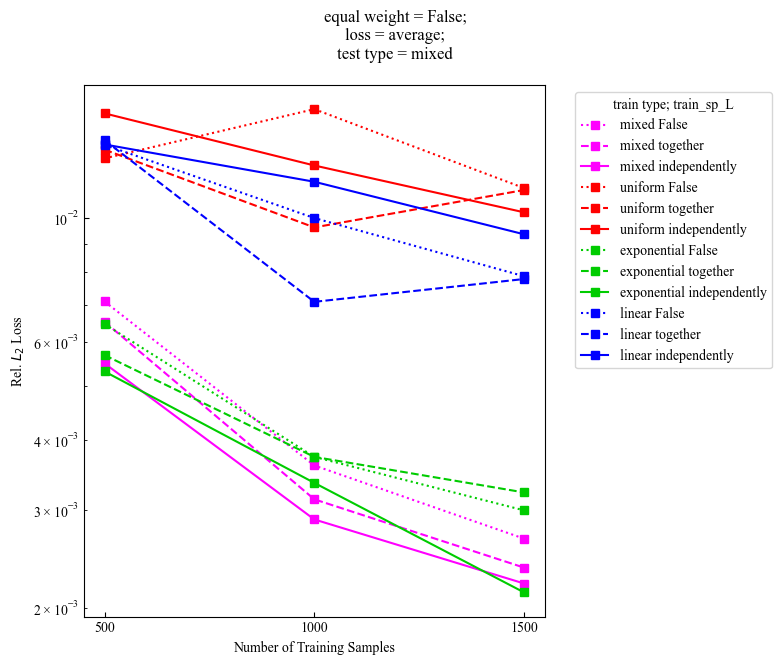

In [ ]:
import json
from itertools import product
import matplotlib.pyplot as plt
def plot_trendency(data, plot_equal_weights, plot_loss_types , plot_train_types, plot_train_sp_Ls, plot_test_types):
    '''
    data[equalweight][loss_type][n_train][train_type][train_sp_L][test_type]
    datasize:  500, 1000, 1500
    loss_type: average, worst
    train_type: exponential , ...
    train_sp_L: False, together, independently
    test_type: exponential, ...

    '''

    plt.figure(figsize=(8, 6))
    # colors = ["m", "tomato", "dodgerblue"]
    # line_styles = ["-", ":", "--"]  
    line_styles_dict = {'independently': '-', 'False': 'dotted', 'together': '--'}
    color_dict = {'mixed': (1,0,1), 'uniform': (1,0,0), 'linear': (0,0,1), 'exponential': (0,0.8,0)}
    plt.rcParams["xtick.direction"] = "in"
    plt.rcParams["ytick.direction"] = "in"
    plt.rcParams["font.family"] = "Times New Roman"

    all_lists = [plot_equal_weights, plot_loss_types , plot_train_types, plot_train_sp_Ls, plot_test_types]
    name_list = ['equal weight', 'loss','train type','train_sp_L','test type']
    fixed_index = [i for i , plot_list in enumerate(all_lists) if len(plot_list)==1]
    for types in product(*all_lists):
        
        equalweight,loss_type,train_type,train_sp_L,test_type = types
        loss0 = data[equalweight][loss_type]['500'][train_type][train_sp_L][test_type]
        loss1 = data[equalweight][loss_type]['1000'][train_type][train_sp_L][test_type]
        loss2 = data[equalweight][loss_type]['1500'][train_type][train_sp_L][test_type]

        label = ' '.join([plot_type for i, plot_type in enumerate(types) if i not in fixed_index])
        plt.semilogy(
            [500, 1000, 1500],
            [loss0, loss1, loss2],
            color=color_dict[train_type],
            linestyle=line_styles_dict[train_sp_L],
            marker="s",
            label= label,
        )
    subtitle = '; '.join([name for i, name in enumerate(name_list) if i not in fixed_index])
    plt.xlabel("Number of Training Samples")
    plt.ylabel(r"Rel. $L_2$ Loss")
    plt.legend(title=subtitle, bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.xticks([500, 1000, 1500])

    title_list1 = [name_list[i] for i in fixed_index]
    title_list2 = [all_lists[i][0] for i in fixed_index]
    title_list = [a + ' = ' + b for a,b in zip(title_list1,title_list2)]
    title = ';\n'.join(title_list)
    plt.suptitle(title, y=1.1)
    
    plt.savefig(f"figure_trendency/compare_{subtitle}.png", format="png", dpi=512, bbox_inches="tight")
    plt.show()

with open('data.json', 'r') as f:
    data_loaded = json.load(f)


plot_equal_weights = ['False']
plot_loss_types = ['average']
# plot_loss_types = ['worst']
# plot_train_types = ['mixed']
plot_train_types = ['mixed', 'uniform', 'exponential', 'linear']
plot_train_sp_Ls = ['False', 'together', 'independently']
# plot_train_sp_Ls = ['False']
plot_test_types = ['mixed']
# plot_test_types = ['mixed', 'uniform', 'exponential', 'linear']
plot_trendency(data_loaded, plot_equal_weights,plot_loss_types , plot_train_types, plot_train_sp_Ls, plot_test_types)